In [1]:
# Hints: 
# Keep the camera a bit outside the radius of the ball.
xml_2dof = """
<mujoco model="2 dof ball">
    <compiler angle="radian"/>
	<option timestep="0.002" iterations="1" ls_iterations="4" solver="Newton" gravity="0 0 -9.81">
		<flag eulerdamp="disable"/>
	</option>
    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="20 20 .125" type="plane" material="MatPlane" group="1"/>
        <body name="ball" pos="0 0 0.2">
            <camera name="fwd" pos="0 0.11 0" xyaxes="1 0 0 0 0 1"/>
            <joint axis="1 0 0" pos="0 0 -0.1" limited="false" name="rootx" type="slide"/>
            <joint axis="0 1 0" pos="0 0 -0.1" limited="false" name="rooty" type="slide"/>
            <joint axis="0 0 1" pos="0 0 -0.1" limited="false" name="rotz" type="hinge"/>
            <geom name="ball_geom" size="0.1" type="sphere" conaffinity="0" contype="1"/>
        </body>
    </worldbody>
    
    <actuator>
        <motor ctrllimited="true" ctrlrange="-1.0 1.0" gear="50.0" joint="rootx"/>
        <motor ctrllimited="true" ctrlrange="-1.0 1.0" gear="50.0" joint="rooty"/>
        <motor ctrllimited="true" ctrlrange="-1.0 1.0" gear="50.0" joint="rotz"/>
    </actuator>
    
    <asset>
        <texture type="skybox" builtin="gradient" rgb1=".4 .5 .6" rgb2="0 0 0"
            width="100" height="100"/>
        <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture type="2d" name="texplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
        markrgb="0.8 0.8 0.8" width="100" height="100"/>
        <material name="MatPlane" texture="texplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>
</mujoco>
"""

# <geom name="obst" size="0.1" type="cylinder" fromto="0 1 0 0 1 1" conaffinity="1" contype="0"/>

In [2]:
import numpy as np
import xml.etree.ElementTree as ET

# Programmatic obstacle generation
obstacle_locs = np.array([
    [0, 2],
    [0.5, 2],
    # [-0.5, 2]
])

# xml_obsts = []
root = ET.fromstring(xml_2dof)

for i in range(obstacle_locs.shape[0]):
    cl = obstacle_locs[i]
    xml_obst = f"""<geom name="obst_{i}" size="0.1" type="capsule" fromto="{cl[0]} {cl[1]} 0 {cl[0]} {cl[1]} 1" conaffinity="1" contype="0"/>"""
    # xml_obsts.append(ET.fromstring(xml_obst))
    
    e_body = root.find("worldbody")
    e_body.append(ET.fromstring(xml_obst))

xml_2dof = ET.tostring(root)    

In [3]:
import mujoco
from mujoco import mjx
import mediapy as media 
import jax 
import jax.numpy as jp

model = mujoco.MjModel.from_xml_string(xml_2dof)
renderer = mujoco.Renderer(model)


""

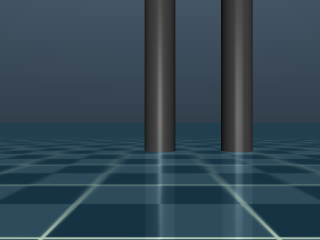

In [4]:
# Snapshot
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fwd")
media.show_image(renderer.render())

# Ray Tracing

Remember:
- [ ] Don't ray-trace the floor
- [ ] Basic function using MJX
- [ ] Parallelize
    - def render()
    - vmap(render())
- [ ] Only compute the image plane coordintaes once.

More:
- [ ] Add a rotational DOF. Retest the model with rotation.

Bug report: 
- [ ] Wrong values with un-normalized vecs.

In [8]:
mx = mjx.put_model(model)
data = mujoco.MjData(model)
dx = mjx.put_data(model, data)

dx = mjx.forward(mx, dx)

In [28]:
def normalise(v):
    return v / jp.linalg.norm(v)

b_normalise = jax.vmap(jax.vmap(normalise))

dcam_pars = {
    'fov_y': 45,
    'p_x': 100,
    'p_y': 100
}

def get_vecs_cf(dcam_pars):
    
    # Parameters
    fov_y = dcam_pars['fov_y']
    p_x = dcam_pars['p_x']
    p_y = dcam_pars['p_y']
    
    _fov_y = np.deg2rad(fov_y)

    f = 0.1 # fix the focal length.

    # Dimensions of image plane
    h_ip = np.tan(_fov_y/2)*2*f
    w_ip = h_ip * (p_x/p_y) # Square pixels.

    delta = w_ip / (2*p_x)

    x_coords_ip = np.linspace(-w_ip/2 + delta, w_ip/2 - delta, p_x)

    # We want a grid corresponding to what will be plotted. 0, 0 corresponds to the top left of the image.
    y_coords_ip = np.flip(np.linspace(-h_ip/2 + delta, h_ip/2 - delta, p_y))

    xx, yy = np.meshgrid(x_coords_ip, y_coords_ip)

    # The ray vectors expressed in the camera frame.
    vecs_cf = np.concatenate([
        np.expand_dims(xx, axis=2),
        np.expand_dims(yy, axis=2),
        -1 * np.ones(xx.shape + (1,)) * f], # Camera looks down the negative z direction.
        axis=2)
    
    return vecs_cf

def cf2gf(vecs_cf, mjx_data, cam_ind):
    """ gf for general frame.
    """
    
    # Transform to the world frame.
    cam_bases = mjx_data.cam_xmat[cam_ind]
    vecs_gf = np.matmul(cam_bases, np.expand_dims(vecs_cf, 3)) # matmul treats as stack of matricies.

    vecs_gf = np.squeeze(vecs_gf)

    # Normalize each vector into a direction vector.
    vecs_gf = b_normalise(vecs_gf)
    
    return vecs_gf

In [21]:
# mask = jp.array([True, False, False, False, False, False])
# mask = (1, 0, 0, 0, 0, 0)
mask = None

In [22]:
vecs_cf = get_vecs_cf(dcam_pars)
vecs_gf = cf2gf(vecs_cf, dx, 0)

from functools import partial
f_ray = jax.jit(partial(mjx.ray, geomgroup = mask))

in_ax = (None,)*3 + (0,)
f_mray = jax.vmap(jax.vmap(f_ray, in_axes=in_ax), in_axes= in_ax)

dist, geom = f_mray(mx, dx, dx.cam_xpos[0], vecs_gf)

""

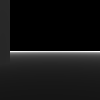

In [23]:
media.show_image(dist)

In [31]:
duration = 2  # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
depth_frames = []

mujoco.mj_resetData(model, data)  # Reset state and time.
ctrl = np.array([0, 0.1, -0.0001])

while data.time < duration:
  data.ctrl = ctrl
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, "fwd")
    pixels = renderer.render()
    frames.append(pixels)
    
    dx = mjx.put_data(model, data)
    vecs_gf = cf2gf(vecs_cf, dx, 0)
    dist, geom = f_mray(mx, dx, dx.cam_xpos[0], vecs_gf)
    depth_frames.append(dist)
    
media.show_video(frames, fps=framerate)

In [32]:
media.show_video(depth_frames, fps=framerate)

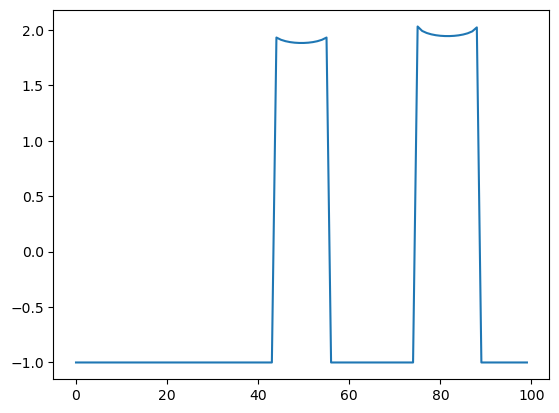

In [19]:
import matplotlib.pyplot as plt
dist = depth_frames[0]
plt.plot(dist[10,:])